---
layout: post
Title: Survey of Various SIR Models
category: data science
tags:
    - python
    - notebook
    - COVID-19
---

To learn more about how COVID-19 can properly be modeled, I will be diving into the different extensions and versions of compartmental models to predict the spread of global pandemics.

# Why include the entire world population in model?

In my [previous post]({{ }}{%  %}) I "cheated" by setting China's population as the sum of the people accounted for in the data. This was a safe assumption for China, as the vast majority of people that will ever be infected already have. If I were to fit the SIR model to China's virus data in the context of a world-scale population, the model will not fit nearly as well as we initially saw (as we will see in this post). However, with data that we have for most of the rest of the world, where the virus is not close to recovering, using this strategy on the world data would give disproportionately low results. As a "global pandemic" I thought it would be productive to see if we could fit China's data in the context of a global population to see if we could find a model robust enough to predict the spread of a nominally large, but relative to the global population small number of infections. Unfortunately, our model will probably have worse results in the short term, but may have better results for long term predictions, which can show us a clearer picture of how many people we can expect to be infected in the next few months.

# Models to consider

- SIR: Susceptible, Infected, Removed
    - This is the baseline model I used in my previous post. This is an excellent model, but as will be shown it is not accurate enough to take 
- SEIR: Susceptible, Exposed, Infected, Removed
    - One of the reasons that COVID-19 spread so quickly was because of its relatively long ([sources](https://www.cdc.gov/coronavirus/2019-ncov/hcp/faq.html) say anywhere between 2 - 14 days) incubation period. During this time, an individual may be able to spread the disease without knowing, which is one of the contributing factors to the increase of infections.
- SIQR: Susceptible, Infected, Quarantined, Removed
    - A reason that China was able to control the spread of the virus so effectively is because it has the power to impose strict quarantine regulations. A quarantine can contribute to how - with respect to the full population of China of about 1.4 billion - relatively few confirmed infections appear (at the time of writing about 82 thousand).
- SDIR: Susceptible, Distant, Infected, Removed
    - Very similar to the previous model, yet in this model people may "distance" themselves before getting infected in the first place. Hopefully this model will be able to explain how effective social distancing is while fighting a global pandemic. Here, the number of distanced people is dependent on the number of people who are infected - i.e. the larger the spread of the infection, the more concerned people practice social distancing.

### Method

Similar to my last post, my metric for accuracy is the mean squared log error between the 7 day prediction of the fitted model and the validation set (last 7 days we have data for). After fitting all models to the training data we will compile the accuracy results, find a model robust enough to consider the virus in the context of a large global population, and make long term predictions on the virus' global spread.

# Examples of each model

In [25]:
import os
import glob
import numpy as np
import pandas as pd
from git import Repo
import seaborn as sns
from scipy import optimize
from datetime import datetime
from datetime import timedelta
from scipy.integrate import odeint
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_log_error as MSLE

In [26]:
def SIR(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = - beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def SEIR(y, t, N, beta, gamma, sigma):
    S, E, I, R = y
    dSdt = - beta * S * (I + E) / N
    dEdt = beta * S * (I + E) / N - sigma * E
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

def SIQR(y, t, N, beta, gamma, sigma):
    S, I, Q, R = y
    dSdt = - beta * S * I / N
    dIdt = beta * S * I / N - (gamma + sigma) * I
    dQdt = sigma * I - gamma * Q
    dRdt = gamma * (I + Q)
    return dSdt, dIdt, dQdt, dRdt

def SDIR(y, t, N, beta, gamma, sigma, mu):
    S, D, I, R = y
    dSdt = - (beta + sigma) * S * I / N + mu * D
    dDdt = sigma * S * I / N - mu * D
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dDdt, dIdt, dRdt

## SIR

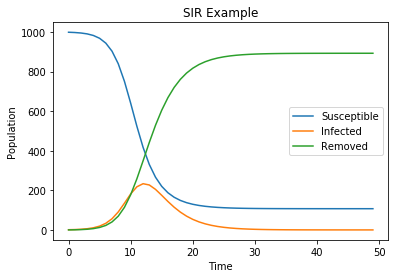

In [27]:
N = 1000
init_cond = (N - 1), 1, 0
beta, gamma = 1, 0.4
t = np.arange(50)
ret = odeint(SIR, init_cond, t, args=(N, beta, gamma))
result = ret.T
compartments = ["Susceptible", "Infected", "Removed"]

plt.title("SIR Example")
for C, name in zip(result, compartments):
    plt.plot(t, C, label=name)
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.show()

## SEIR

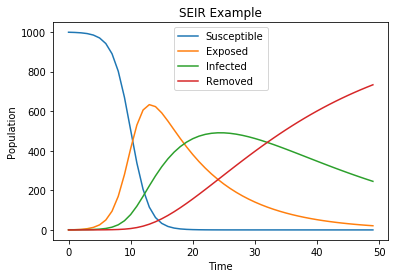

In [28]:
N = 1000
init_cond = (N - 1), 0, 1, 0
beta, gamma, sigma = 0.7, 0.05, 0.1
t = np.arange(50)
ret = odeint(SEIR, init_cond, t, args=(N, beta, gamma, sigma))
result = ret.T
compartments = ["Susceptible", "Exposed", "Infected", "Removed"]

plt.title("SEIR Example")
for C, name in zip(result, compartments):
    plt.plot(t, C, label=name)
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.show()

## SIQR

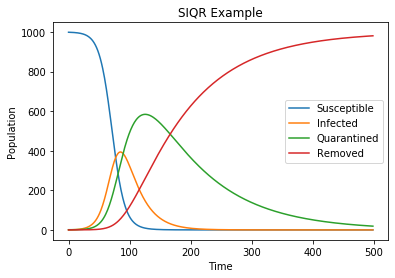

In [29]:
N = 1000
init_cond = (N - 1), 0, 1, 0
beta, gamma, sigma = 0.1, 0.01, 0.04
t = np.arange(500)
ret = odeint(SEIR, init_cond, t, args=(N, beta, gamma, sigma))
result = ret.T
compartments = ["Susceptible", "Infected", "Quarantined", "Removed"]

plt.title("SIQR Example")
for C, name in zip(result, compartments):
    plt.plot(t, C, label=name)
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.show()

## SDIR

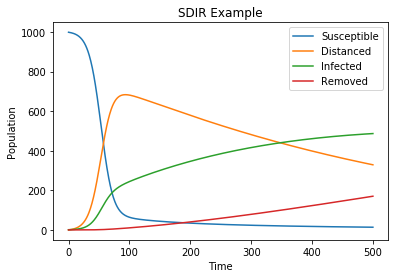

In [30]:
N = 1000
init_cond = (N - 1), 0, 1, 0
beta, gamma, sigma, mu = 0.1, 0.001, 0.4, 0.01
t = np.linspace(0, 500, 1000)
ret = odeint(SDIR, init_cond, t, args=(N, beta, gamma, sigma, mu))
result = ret.T
compartments = ["Susceptible", "Distanced", "Infected", "Removed"]

plt.title("SDIR Example")
for C, name in zip(result, compartments):
    plt.plot(t, C, label=name)
plt.ylabel("Population")
plt.xlabel("Time")
plt.legend()
plt.show()

Let's fetch our data like last time and try to fit the same data to each model.

# Fitting Models

In [31]:
repo_path = "../../../"
data_root = "../../../scripts/COVID-19/csse_covid_19_data/csse_covid_19_time_series/"
repo = Repo(repo_path)
output = repo.git.submodule('update', '--remote')

In [32]:
world_pop = 7.86e9
china_pop = 7.86e9

global_confirmed = pd.read_csv(os.path.join(data_root, "time_series_covid19_confirmed_global.csv"))
global_deaths = pd.read_csv(os.path.join(data_root, "time_series_covid19_deaths_global.csv"))
global_recovered = pd.read_csv(os.path.join(data_root, "time_series_covid19_recovered_global.csv"))

china_confirmed = global_confirmed[global_confirmed['Country/Region'] == "China"].copy()
china_deaths = global_deaths[global_deaths['Country/Region'] == "China"].copy()
china_recovered = global_recovered[global_recovered['Country/Region'] == "China"].copy()
china_deaths.drop(columns=["Province/State", "Country/Region", "Lat", "Long"], inplace=True)
china_confirmed.drop(columns=["Province/State", "Country/Region", "Lat", "Long"], inplace=True)
china_recovered.drop(columns=["Province/State", "Country/Region", "Lat", "Long"], inplace=True)
global_deaths.drop(columns=["Province/State", "Country/Region", "Lat", "Long"], inplace=True)
global_confirmed.drop(columns=["Province/State", "Country/Region", "Lat", "Long"], inplace=True)
global_recovered.drop(columns=["Province/State", "Country/Region", "Lat", "Long"], inplace=True)


global_confirmed = global_confirmed.sum()
global_deaths = global_deaths.sum()
global_recovered = global_recovered.sum()
china_confirmed = china_confirmed.sum()
china_recovered = china_recovered.sum()
china_deaths = china_deaths.sum()

world_df = pd.DataFrame({
    "Infected": global_confirmed - global_recovered.values - global_deaths.values,
    "Susceptible": world_pop - global_confirmed.values,
    "Removed": global_recovered + global_deaths.values
})

china_df = pd.DataFrame({
    "Infected": china_confirmed - china_recovered.values - china_deaths.values,
    "Susceptible": china_pop - china_confirmed.values,
    "Removed": china_recovered + china_deaths.values
})
# china_df["Susceptible"] = china_df.sum(axis = 1).max() - china_df["Infected"].values - china_df["Removed"].values

In [33]:
china_df.head()

,Infected,Susceptible,Removed
1/22/20,503,7.859999e+09,45
1/23/20,595,7.859999e+09,48
1/24/20,858,7.859999e+09,62
1/25/20,1325,7.859999e+09,81
1/26/20,1970,7.859998e+09,105


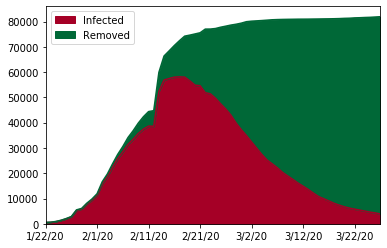

In [34]:
china_df.drop(columns="Susceptible").plot.area(colormap="RdYlGn")

In [35]:
def train_valid_split(df, valid_size = 7):
    x = np.arange(len(df))
    S = df['Susceptible'].values
    I = df['Infected'].values
    R = df['Removed'].values
    
    x_train = x[:-valid_size]
    S_train = S[:-valid_size]
    I_train = I[:-valid_size]
    R_train = R[:-valid_size]
    
    x_valid = x[-valid_size:]
    S_valid = S[-valid_size:]
    I_valid = I[-valid_size:]
    R_valid = R[-valid_size:]
    
    return (x_train, S_train, I_train, R_train), (x_valid, S_valid, I_valid, R_valid)

def plot_data(title, x_train, y_train, x_valid, y_valid, y_fit = None, y_pred = None):
    plt.title(title)
    plt.plot(x_train, y_train, 'o', label="Train")
    plt.plot(x_valid, y_valid, 'o', label="Valid")
    if not y_fit is None:
        plt.plot(x_train, y_fit, label="Fit")
    if not y_pred is None:
        plt.plot(x_valid, y_pred, label="Prediction")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Population")
    plt.show()
    if not y_pred is None:
        print(title, "MSLE: {:.4e}".format(MSLE(y_valid, y_pred)))
        print()

In [36]:
def opt_SIR(t, beta, gamma, init_cond, N):
    ret = odeint(SIR, init_cond, t, args=(N, beta, gamma))
    return np.concatenate(ret.T)

def opt_SEIR(t, beta, gamma, sigma, init_cond, N):
    ret = odeint(SEIR, init_cond, t, args=(N, beta, gamma, sigma))
    S, E, I, R = ret.T
    return np.concatenate([S + E, I, R])

def opt_SIQR(t, beta, gamma, sigma, init_cond, N):
    ret = odeint(SIQR, init_cond, t, args=(N, beta, gamma, sigma))
    S, I, Q, R = ret.T
    return np.concatenate([S, I + Q, R])

def opt_SDIR(t, beta, gamma, sigma, mu, init_cond, N):
    ret = odeint(SDIR, init_cond, t, args=(N, beta, gamma, sigma, mu))
    S, D, I, R = ret.T
    return np.concatenate([S + D, I, R])


In [37]:
valid_size = 7
train, valid = train_valid_split(china_df)
x_train, S_train, I_train, R_train = train
x_valid, S_valid, I_valid, R_valid = valid

S0 = S_train[0]
I0 = I_train[0]
R0 = R_train[0]
N = S0 + I0 + R0

## SIR

In [38]:
init_cond = S0, I0, R0
fit_args, fit_cov = optimize.curve_fit(
    lambda t, b, g: opt_SIR(t, b, g, init_cond, N),
    x_train,
    np.concatenate([S_train, I_train, R_train]),
    bounds=((0, 0), (np.inf, np.inf)),
    p0=(1, 0))
fit_args

array([2.50919813, 2.50257258])

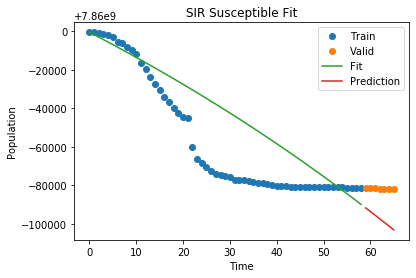

SIR Susceptible Fit MSLE: 4.2099e-12



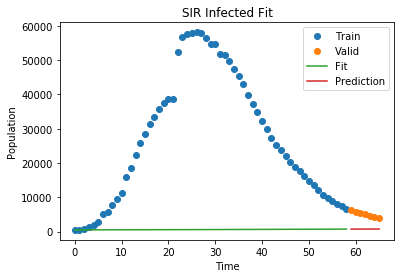

SIR Infected Fit MSLE: 3.5630e+00



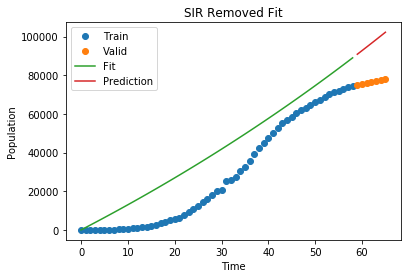

SIR Removed Fit MSLE: 5.4213e-02



In [39]:
args = (N,) + tuple(fit_args)
ret = odeint(SIR, init_cond, np.concatenate([x_train, x_valid]), args=args)
S, I, R = ret.T

S_fit = S[:-valid_size]
S_pred = S[-valid_size:]
I_fit = I[:-valid_size]
I_pred = I[-valid_size:]
R_fit = R[:-valid_size]
R_pred = R[-valid_size:]

plot_data("SIR Susceptible Fit", x_train, S_train, x_valid, S_valid, S_fit, S_pred)
plot_data("SIR Infected Fit", x_train, I_train, x_valid, I_valid, I_fit, I_pred)
plot_data("SIR Removed Fit", x_train, R_train, x_valid, R_valid, R_fit, R_pred)

## SEIR

In [40]:
init_cond = S0, 0, I0, R0
fit_args, fit_cov = optimize.curve_fit(
    lambda t, b, g, s: opt_SEIR(t, b, g, s, init_cond, N),
    x_train,
    np.concatenate([S_train, I_train, R_train]),
    bounds=((0, 0, 0), (np.inf, np.inf, np.inf)),
    p0=(1, 0, 0))
fit_args

array([6.18868008e+00, 5.74897744e-02, 2.53817867e-07])

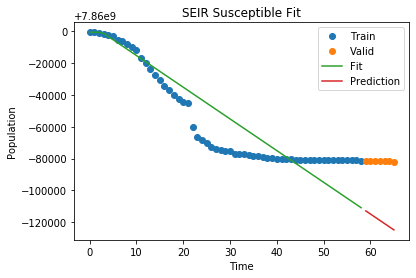

SEIR Susceptible Fit MSLE: 2.2754e-11



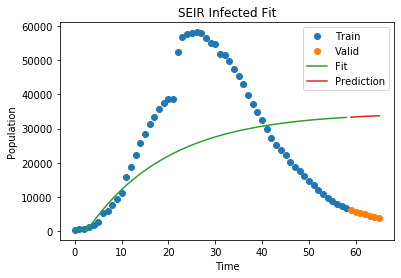

SEIR Infected Fit MSLE: 3.6702e+00



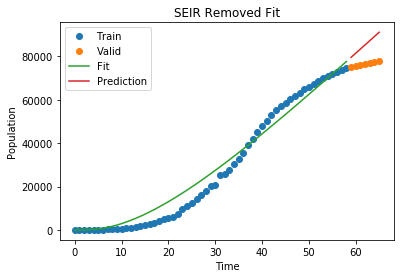

SEIR Removed Fit MSLE: 1.2632e-02



In [41]:
args = (N,) + tuple(fit_args)
ret = odeint(SEIR, init_cond, np.concatenate([x_train, x_valid]), args=args)
S, E, I, R = ret.T
S = S + E

S_fit = S[:-valid_size]
S_pred = S[-valid_size:]
I_fit = I[:-valid_size]
I_pred = I[-valid_size:]
R_fit = R[:-valid_size]
R_pred = R[-valid_size:]

plot_data("SEIR Susceptible Fit", x_train, S_train, x_valid, S_valid, S_fit, S_pred)
plot_data("SEIR Infected Fit", x_train, I_train, x_valid, I_valid, I_fit, I_pred)
plot_data("SEIR Removed Fit", x_train, R_train, x_valid, R_valid, R_fit, R_pred)

## SIQR

In [42]:
init_cond = S0, I0, 0, R0
fit_args, fit_cov = optimize.curve_fit(
    lambda t, b, g, s: opt_SIQR(t, b, g, s, init_cond, N),
    x_train,
    np.concatenate([S_train, I_train, R_train]),
    bounds=((0, 0, 0), (np.inf, np.inf, np.inf)),
    p0 = (1, 0, 0))
fit_args

array([6.85121823, 0.04044937, 6.84323426])

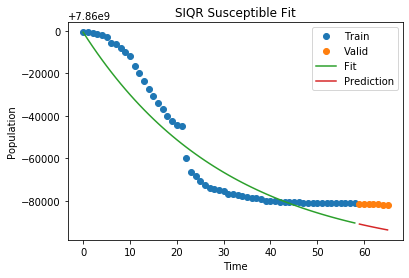

SIQR Susceptible Fit MSLE: 1.9039e-12



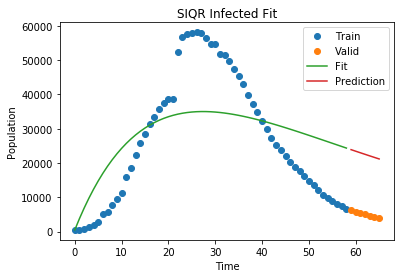

SIQR Infected Fit MSLE: 2.2931e+00



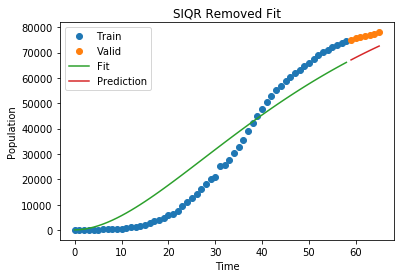

SIQR Removed Fit MSLE: 8.5679e-03



In [43]:
args = (N,) + tuple(fit_args)
ret = odeint(SIQR, init_cond, np.concatenate([x_train, x_valid]), args=args)
S, I, Q, R = ret.T
I = I + Q

S_fit = S[:-valid_size]
S_pred = S[-valid_size:]
I_fit = I[:-valid_size]
I_pred = I[-valid_size:]
R_fit = R[:-valid_size]
R_pred = R[-valid_size:]

plot_data("SIQR Susceptible Fit", x_train, S_train, x_valid, S_valid, S_fit, S_pred)
plot_data("SIQR Infected Fit", x_train, I_train, x_valid, I_valid, I_fit, I_pred)
plot_data("SIQR Removed Fit", x_train, R_train, x_valid, R_valid, R_fit, R_pred)

## SDIR

In [44]:
init_cond = S0, 0, I0, R0
fit_args, fit_cov = optimize.curve_fit(
    lambda t, b, g, s, m: opt_SDIR(t, b, g, s, m, init_cond, N),
    x_train,
    np.concatenate([S_train, I_train, R_train]),
    bounds=((0, 0, 0, 0), (np.inf, np.inf, np.inf, np.inf)),
    p0 = (1, 0, 0, 0))
fit_args

array([3.20177915e-01, 4.32734582e-02, 3.06340729e+04, 2.95564621e-18])

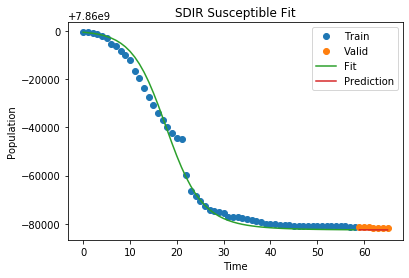

SDIR Susceptible Fit MSLE: 1.4793e-14



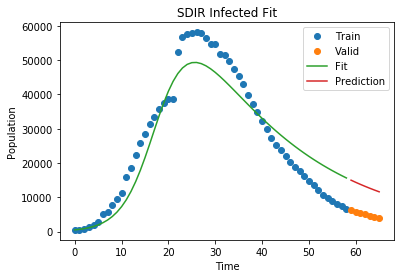

SDIR Infected Fit MSLE: 9.5711e-01



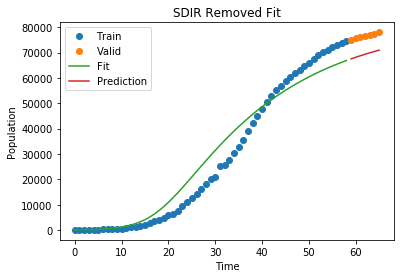

SDIR Removed Fit MSLE: 9.9903e-03



In [45]:
args = (N,) + tuple(fit_args)
ret = odeint(SDIR, init_cond, np.concatenate([x_train, x_valid]), args=args)
S, D, I, R = ret.T
S = S + D

S_fit = S[:-valid_size]
S_pred = S[-valid_size:]
I_fit = I[:-valid_size]
I_pred = I[-valid_size:]
R_fit = R[:-valid_size]
R_pred = R[-valid_size:]

plot_data("SDIR Susceptible Fit", x_train, S_train, x_valid, S_valid, S_fit, S_pred)
plot_data("SDIR Infected Fit", x_train, I_train, x_valid, I_valid, I_fit, I_pred)
plot_data("SDIR Removed Fit", x_train, R_train, x_valid, R_valid, R_fit, R_pred)

## Compiled Results

| | Susceptible MSLE | Infected MSLE | Removed MSLE |
| --- | --- | --- | --- |
| SIR | $4.2 \times 10^{12}$ | $3.6$ | $5.4 \times 10^{-2}$  |
| SEIR | $2.2 \times 10^{-11}$ |  $3.7$ | $1.3 \times 10^{-2}$ |
| SIQR | $1.9 \times 10^{-12}$ | $2.3$ | $8.6 \times 10^{-3}$ |
| SDIR | $1.5 \times 10^{-14}$ | $0.96$ | $1.0 \times 10^{-2}$ |

It looks like the SDIR model can fit the China data the best, even in a global population context! let's see what happens when we fit it to our world data and make some new (and hopefully more reasonable) predictions!

# Fitting to world data

Our model seems to be robust enough to make relatively accurate predictions. However, our world data is still developing at the time of writing and this particular dataset does not say how many people are distancing.

In [46]:
df = world_df
x = np.arange(len(df))
S = df['Susceptible'].values
I = df['Infected'].values
R = df['Removed'].values

init_cond = S0, 0, I0, R0
fit_args, fit_cov = optimize.curve_fit(
    lambda t, b, g, s, m: opt_SDIR(t, b, g, s, m, init_cond, N),
    x,
    np.concatenate([S, I, R]),
    bounds=((0, 0, 0, 0), (np.inf, np.inf, np.inf, np.inf)),
    p0 = (1, 0, 0, 0))
fit_args

array([1.55715196e-01, 4.89177223e-02, 1.43238862e+04, 2.42582296e+00])

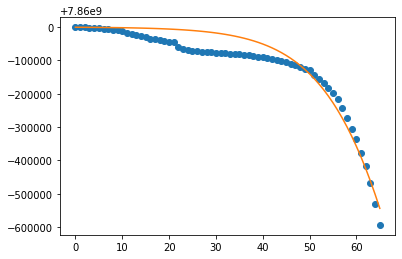

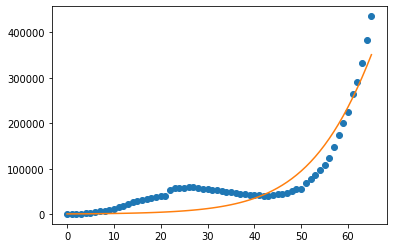

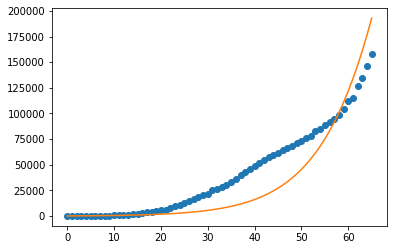

In [47]:
args = (N,) + tuple(fit_args)
ret = odeint(SDIR, init_cond, x, args=args)
S_fit, D_fit, I_fit, R_fit = ret.T
S_fit = S_fit + D_fit

plt.plot(x, S, 'o')
plt.plot(x, S_fit)
plt.show()

plt.plot(x, I, 'o')
plt.plot(x, I_fit)
plt.show()

plt.plot(x, R, 'o')
plt.plot(x, R_fit)
plt.show()

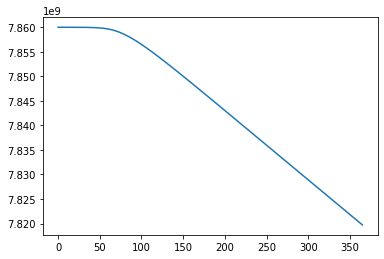

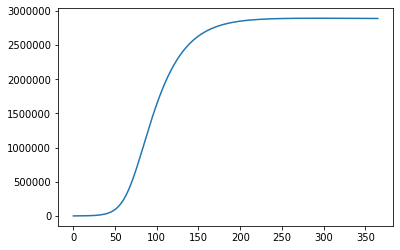

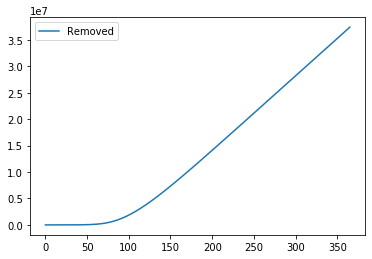

In [48]:
t = np.linspace(0, 365, 10000)
ret = odeint(SDIR, init_cond, t, args=args)
S_pred, D_pred, I_pred, R_pred = ret.T
S_pred = S_pred + D_pred

plt.plot(t, S_pred, label="Susceptible")
plt.show()

plt.plot(t, I_pred, label="Infected")
plt.show()

plt.plot(t, R_pred, label="Removed")
plt.legend()
plt.show()

Hmm. It looks like the way we are fitting our data is not accurately taking social distancing into account. Without social distancing our model looks no different than SIR! Clearly we need to make some assumptions on social distancing before we can make some accurate predictions:

# How is social distancing modeled?

The SDIR model I made follows this ODE:

$$
\frac{dS}{dt} = -\frac{\beta S I}{N} - \sigma S I + \mu D \\
\frac{dD}{dt} = \sigma S I - \mu D \\
\frac{dI}{dt} = \frac{\beta S I}{N} - \gamma I \\
\frac{dR}{dt} = \gamma I
$$